In [1]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('capacitor_discharging.csv')
df_charging = pd.read_csv('capacitor_charging.csv')

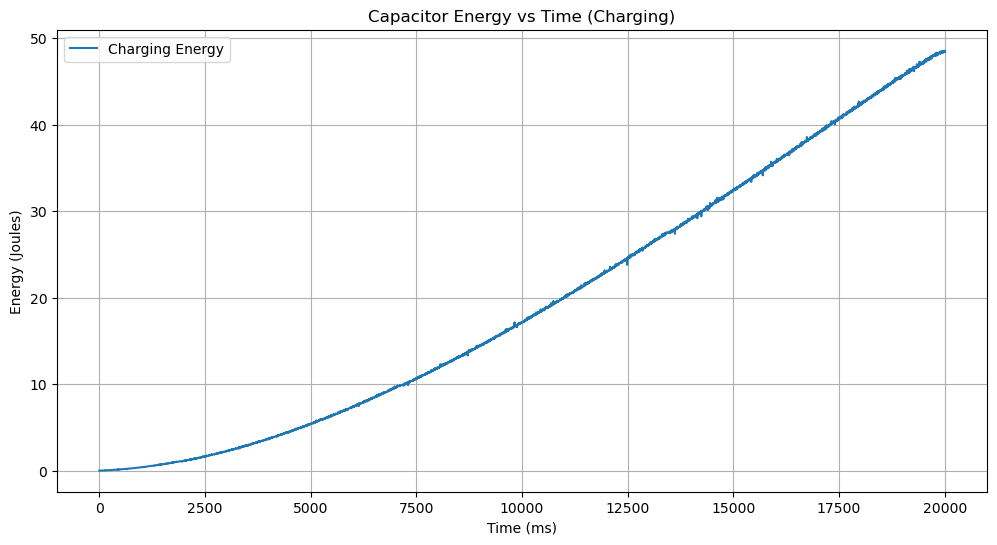

In [2]:
df_charging_clean = df_charging[df_charging.columns[0]].str.split('\t', expand=True)
df_charging_clean.columns = ['time_ms', 'voltage_Va', 'voltage_Vb', 'current_A', 'power_W']
df_charging_clean = df_charging_clean.apply(pd.to_numeric)

df_charging_clean['energy_Vb'] = 0.25 * df_charging_clean['voltage_Vb']**2

plt.figure(figsize=(12, 6))
plt.plot(df_charging_clean['time_ms'], df_charging_clean['energy_Vb'], label='Charging Energy')
plt.xlabel('Time (ms)')
plt.ylabel('Energy (Joules)')
plt.title('Capacitor Energy vs Time (Charging)')
plt.legend()
plt.grid(True)
plt.show()

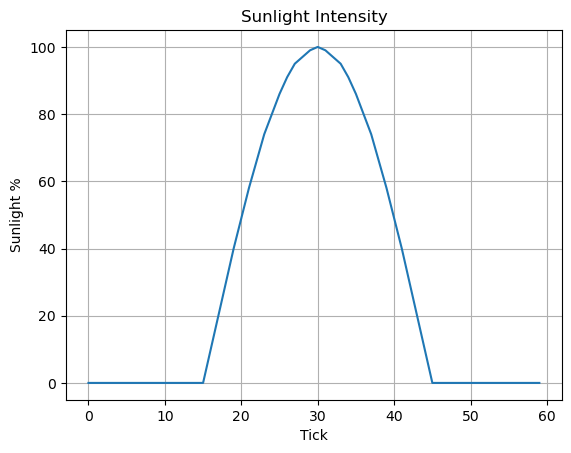

In [4]:
import math
yesterday_url = BASE_URL + ENDPOINTS["yesterday"]
response = requests.get(yesterday_url)
yesterday_data = response.json()

df = pd.DataFrame(yesterday_data)
ticks = df['tick'].tolist()
sun_values = []
for t in ticks:
    SUNRISE = 15
    DAY_LENGTH = 30
    if t < SUNRISE:
        sun = 0
    elif t < SUNRISE + DAY_LENGTH:
        sun = int(math.sin((t-SUNRISE)*math.pi/DAY_LENGTH)*100)
    else:
        sun = 0
    sun_values.append(sun)
df['sun'] = sun_values

df.plot(x='tick', y='sun', kind='line', legend=False)
plt.title('Sunlight Intensity')
plt.xlabel('Tick')
plt.ylabel('Sunlight %')
plt.grid(True)
plt.show()

#sunlight doesn't depend on ticks, so the grpah always gonna look like this:

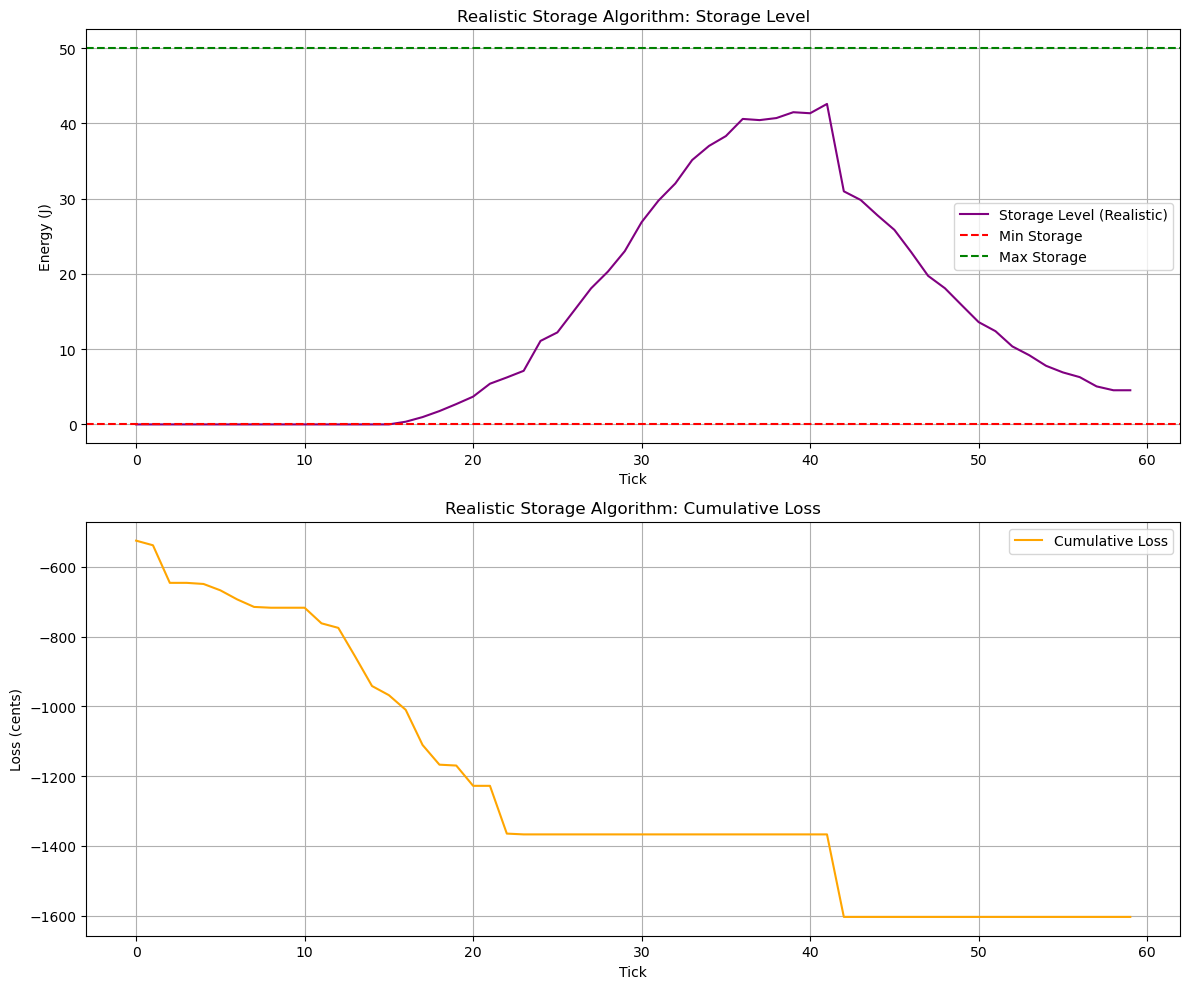

Final loss (realistic): 1603.33 cents
Number of buy actions: 21


In [15]:
import numpy as np

def run_realistic_storage_algorithm(df, defer_df):
    """
    Storage algorithm with exponential charging/discharging constraints.
    Charging/discharging follows E(t) = A * (1 - exp(-t/τ)) for charging,
    and E(t) = A * exp(-t/τ) for discharging.
    """
    # Hardware parameters (example values, adjust as needed)
    MAX_STORAGE = 50
    MIN_STORAGE = 0
    CHARGE_TAU = 3  # time constant for charging (ticks)
    DISCHARGE_TAU = 3 # time constant for discharging (ticks)
    DT = 1  # tick duration

    storage = [0]  # Start with full storage
    actions = []
    profit = 0
    profit_over_time = []

    for i in range(len(df)):
        tick = df['tick'][i]
        sell_price = df.iloc[i]['sell_price']
        buy_price = sell_price * 0.5
        demand = df['demand'][i]
        sun = df['sun'][i]
        current_storage = storage[-1]

        # 1. Solar charging (exponential approach to MAX_STORAGE)
        if sun > 0:
            solar_energy = sun * 0.01 * 5
            # Exponential charging: dE = (A - E) * (1 - exp(-dt/tau))
            charge_possible = (MAX_STORAGE - current_storage) * (1 - np.exp(-DT / CHARGE_TAU))
            actual_charge = min(solar_energy, charge_possible)
            current_storage += actual_charge
            actions.append(f'solar_charge_{actual_charge:.2f}J')

        # 2. Discharge for demand (exponential decay from current storage)
        if demand > 0:
            # Exponential discharge: dE = E * (1 - exp(-dt/tau))
            discharge_possible = current_storage * (1 - np.exp(-DT / DISCHARGE_TAU))
            used_from_storage = min(demand, discharge_possible)
            current_storage -= used_from_storage
            actions.append(f'discharge_{used_from_storage:.2f}J')
            if used_from_storage < demand:
                grid_energy = demand - used_from_storage
                profit -= grid_energy * buy_price
                actions.append(f'buy_{grid_energy:.2f}J')

        # 3. Deferable demands at their start tick
        active_deferables = defer_df[defer_df['start'] == tick]
        for _, row in active_deferables.iterrows():
            energy = row['energy']
            discharge_possible = current_storage * (1 - np.exp(-DT / DISCHARGE_TAU))
            used_from_storage = min(energy, discharge_possible)
            current_storage -= used_from_storage
            actions.append(f'discharge_defer_{used_from_storage:.2f}J')
            if used_from_storage < energy:
                grid_energy = energy - used_from_storage
                profit -= grid_energy * buy_price
                actions.append(f'buy_defer_{grid_energy:.2f}J')

        # 4. Emergency buy if storage below MIN_STORAGE
        if current_storage < MIN_STORAGE:
            buy_amt = MIN_STORAGE - current_storage
            current_storage += buy_amt
            profit -= buy_amt * buy_price
            actions.append(f'emergency_buy_{buy_amt:.2f}J')

        current_storage = max(MIN_STORAGE, min(current_storage, MAX_STORAGE))
        storage.append(current_storage)
        profit_over_time.append(profit)

    return storage[1:], profit_over_time, actions

# Run the realistic algorithm
storage_real, profit_real, actions_real = run_realistic_storage_algorithm(df, defer_df)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(df['tick'], storage_real, label='Storage Level (Realistic)', color='purple')
ax1.axhline(y=MIN_STORAGE, color='r', linestyle='--', label='Min Storage')
ax1.axhline(y=MAX_STORAGE, color='g', linestyle='--', label='Max Storage')
ax1.set_title('Realistic Storage Algorithm: Storage Level')
ax1.set_xlabel('Tick')
ax1.set_ylabel('Energy (J)')
ax1.legend()
ax1.grid(True)

ax2.plot(df['tick'], profit_real, color='orange', label='Cumulative Loss')
ax2.set_title('Realistic Storage Algorithm: Cumulative Loss')
ax2.set_xlabel('Tick')
ax2.set_ylabel('Loss (cents)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final loss (realistic): {-profit_real[-1]:.2f} cents")
print(f"Number of buy actions: {sum('buy' in a for a in actions_real)}")

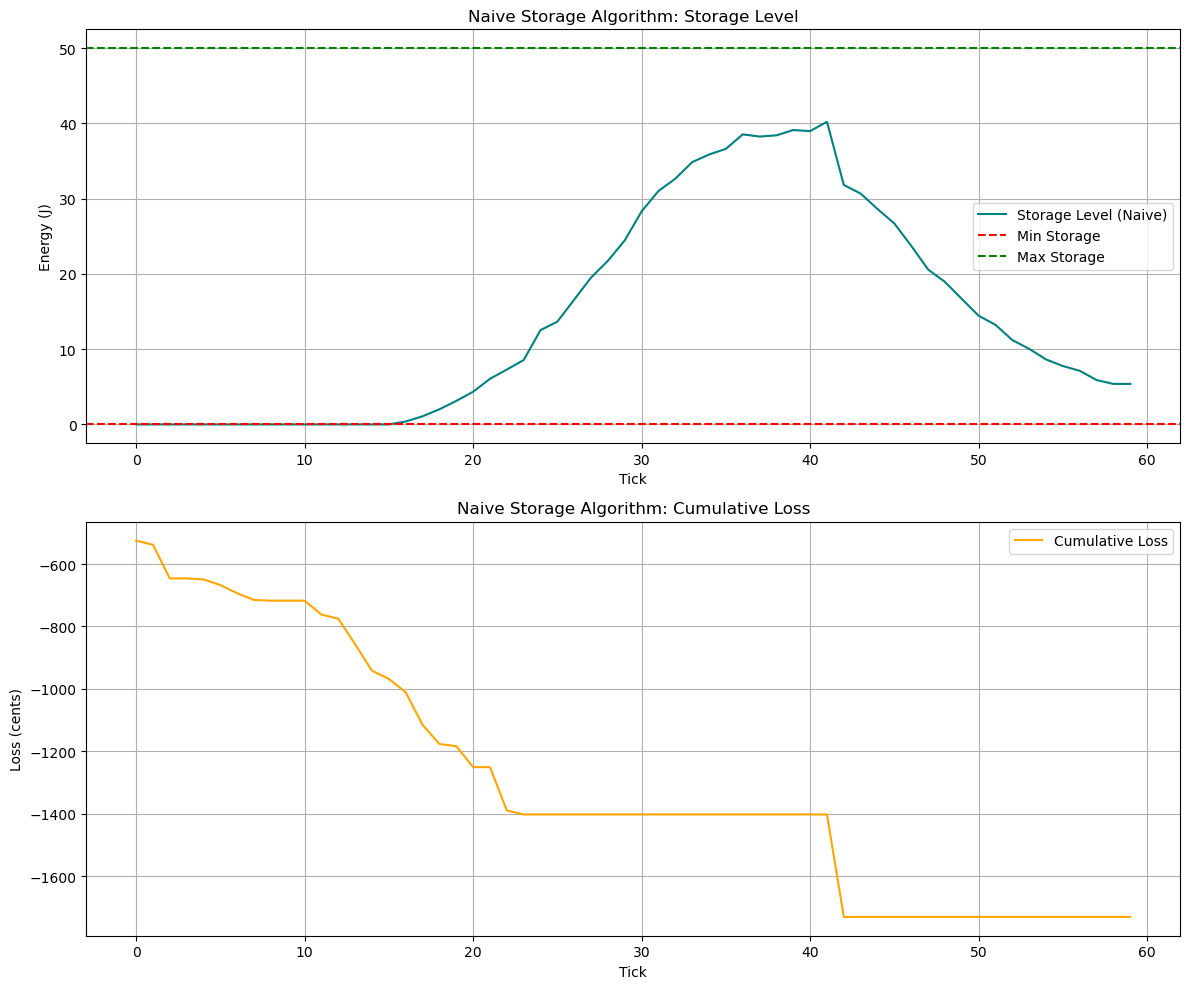

Final loss (naive): 1730.23 cents
Number of buy actions: 21


In [21]:
import numpy as np

def run_naive_storage_algorithm(df, defer_df):
    """
    Naive storage algorithm with exponential charging and discharging:
    Charging: E(t) = A * (1 - exp(-t/τ))
    Discharging: E(t) = E_initial * exp(-t/τ)
    """
    MAX_STORAGE = 50
    MIN_STORAGE = 0
    CHARGE_TAU = 4  # time constant for charging - should be 1.3 if it takes 4 ticks to charge to full storage, but 4 is more realistic and gives leeway. adjust if needed pls
    DISCHARGE_TAU = 4
    DT = 1  # tick duration

    storage = [0]
    actions = []
    profit = 0
    profit_over_time = []

    for i in range(len(df)):
        tick = df['tick'][i]
        sell_price = df.iloc[i]['sell_price']
        buy_price = sell_price * 0.5
        demand = df['demand'][i]
        sun = df['sun'][i]
        current_storage = storage[-1]

        # 1. Solar charging (exponential approach to MAX_STORAGE)
        if sun > 0:
            solar_energy = sun * 0.01 * 5
            charge_possible = (MAX_STORAGE - current_storage) * (1 - np.exp(-DT / CHARGE_TAU))
            actual_charge = min(solar_energy, charge_possible)
            current_storage += actual_charge
            actions.append(f'solar_charge_{actual_charge:.2f}J')

        # 2. Discharge for demand (exponential decay from current storage)
        if demand > 0:
            # Exponential discharge: E(t) = E_initial * exp(-t/τ)
            # Energy delivered in this tick:
            e_initial = current_storage
            e_final = e_initial * np.exp(-DT / DISCHARGE_TAU)
            discharge_possible = e_initial - e_final
            used_from_storage = min(demand, discharge_possible)
            current_storage -= used_from_storage
            actions.append(f'discharge_{used_from_storage:.2f}J')
            if used_from_storage < demand:
                grid_energy = demand - used_from_storage
                profit -= grid_energy * buy_price
                actions.append(f'buy_{grid_energy:.2f}J')

        # 3. Deferable demands at their start tick
        active_deferables = defer_df[defer_df['start'] == tick]
        for _, row in active_deferables.iterrows():
            energy = row['energy']
            e_initial = current_storage
            e_final = e_initial * np.exp(-DT / DISCHARGE_TAU)
            discharge_possible = e_initial - e_final
            used_from_storage = min(energy, discharge_possible)
            current_storage -= used_from_storage
            actions.append(f'discharge_defer_{used_from_storage:.2f}J')
            if used_from_storage < energy:
                grid_energy = energy - used_from_storage
                profit -= grid_energy * buy_price
                actions.append(f'buy_defer_{grid_energy:.2f}J')

        # 4. Emergency buy if storage below MIN_STORAGE
        if current_storage < MIN_STORAGE:
            buy_amt = MIN_STORAGE - current_storage
            current_storage += buy_amt
            profit -= buy_amt * buy_price
            actions.append(f'emergency_buy_{buy_amt:.2f}J')

        current_storage = max(MIN_STORAGE, min(current_storage, MAX_STORAGE))
        storage.append(current_storage)
        profit_over_time.append(profit)

    return storage[1:], profit_over_time, actions

# Run the naive algorithm
storage_naive, profit_naive, actions_naive = run_naive_storage_algorithm(df, defer_df)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(df['tick'], storage_naive, label='Storage Level (Naive)', color='teal')
ax1.axhline(y=MIN_STORAGE, color='r', linestyle='--', label='Min Storage')
ax1.axhline(y=MAX_STORAGE, color='g', linestyle='--', label='Max Storage')
ax1.set_title('Naive Storage Algorithm: Storage Level')
ax1.set_xlabel('Tick')
ax1.set_ylabel('Energy (J)')
ax1.legend()
ax1.grid(True)

ax2.plot(df['tick'], profit_naive, color='orange', label='Cumulative Loss')
ax2.set_title('Naive Storage Algorithm: Cumulative Loss')
ax2.set_xlabel('Tick')
ax2.set_ylabel('Loss (cents)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final loss (naive): {-profit_naive[-1]:.2f} cents")
print(f"Number of buy actions: {sum('buy' in a for a in actions_naive)}")

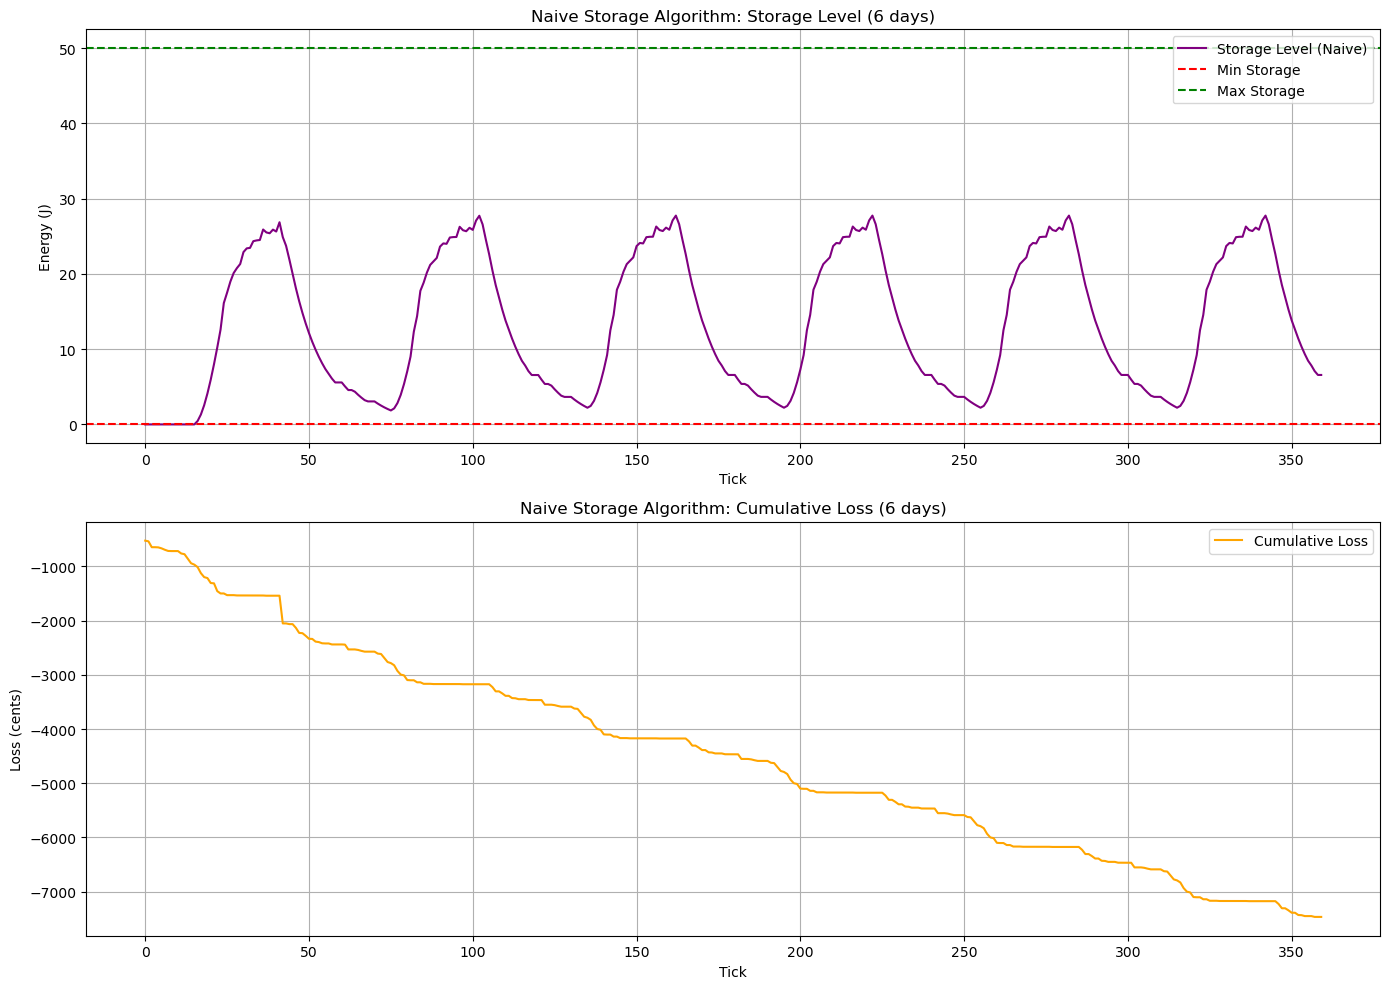

Final loss (naive, 6 days): 7464.80 cents
Final storage after 6 days: 6.57 J
Number of buy actions: 183


In [24]:
# Run simulation with cumulative profit over all days
storage_long = []
profit_long = []
actions_long = []
initial_storage = 0
profit = 0  # Accumulate profit across all days

for day in range(num_days):
    start_idx = day * ticks_per_day
    end_idx = (day + 1) * ticks_per_day
    df_day = df_long.iloc[start_idx:end_idx].reset_index(drop=True)
    defer_df_day = defer_df_long[(defer_df_long['start'] >= start_idx) & (defer_df_long['start'] < end_idx)].copy()
    defer_df_day['start'] -= start_idx
    defer_df_day['end'] -= start_idx

    # Pass profit into the function and return updated profit
    s, p, a = run_realistic_storage_algorithm_long(df_day, defer_df_day, initial_storage)
    # Offset profit for this day by current cumulative profit
    p = [x + profit for x in p]
    profit = p[-1]  # Update cumulative profit

    storage_long.extend(s)
    profit_long.extend(p)
    actions_long.extend(a)
    initial_storage = s[-1]

# Plot results (same as before)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.plot(range(total_ticks), storage_long, label='Storage Level (Naive)', color='purple')
ax1.axhline(y=MIN_STORAGE, color='r', linestyle='--', label='Min Storage')
ax1.axhline(y=MAX_STORAGE, color='g', linestyle='--', label='Max Storage')
ax1.set_title('Naive Storage Algorithm: Storage Level (6 days)')
ax1.set_xlabel('Tick')
ax1.set_ylabel('Energy (J)')
ax1.legend()
ax1.grid(True)

ax2.plot(range(total_ticks), profit_long, color='orange', label='Cumulative Loss')
ax2.set_title('Naive Storage Algorithm: Cumulative Loss (6 days)')
ax2.set_xlabel('Tick')
ax2.set_ylabel('Loss (cents)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final loss (naive, 6 days): {-profit_long[-1]:.2f} cents")
print(f"Final storage after 6 days: {storage_long[-1]:.2f} J")
print(f"Number of buy actions: {sum('buy' in a for a in actions_long)}")


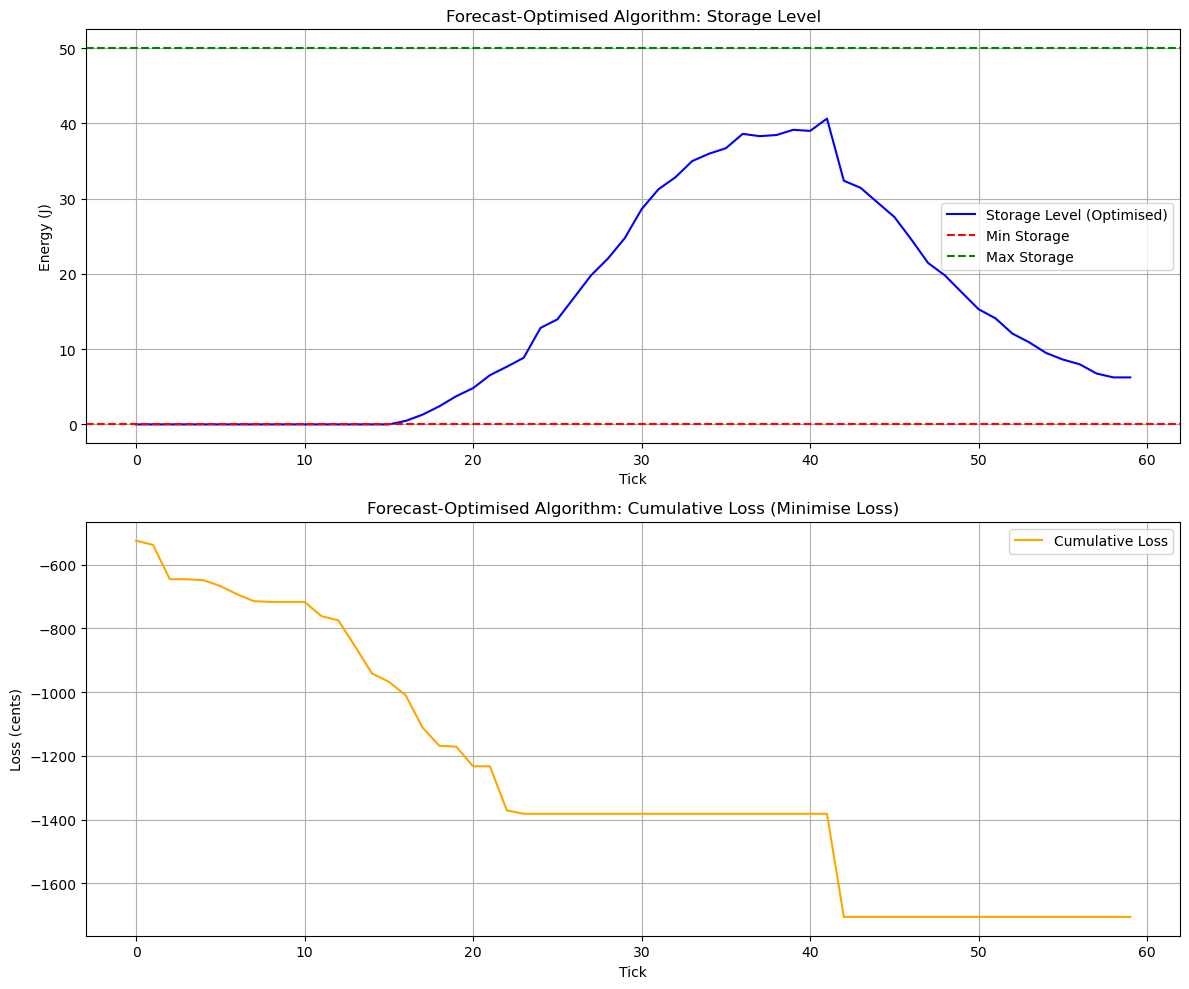

Final loss (optimised): 1705.37 cents
Number of buy actions: 21


In [32]:
def run_optimised_storage_algorithm(df, defer_df, window=10):
    """
    Optimised storage algorithm using a moving average forecast for sunlight and demand.
    Improves upon the naive algorithm by anticipating future solar and demand.
    """
    MAX_STORAGE = 50
    MIN_STORAGE = 0
    CHARGE_TAU = 4
    DISCHARGE_TAU = 4
    DT = 1

    storage = [0]
    actions = []
    profit = 0
    profit_over_time = []

    # Compute moving averages for sun and demand
    sun_forecast = df['sun'].rolling(window, min_periods=1).mean().shift(-window//2).fillna(method='bfill').fillna(method='ffill')
    demand_forecast = df['demand'].rolling(window, min_periods=1).mean().shift(-window//2).fillna(method='bfill').fillna(method='ffill')

    for i in range(len(df)):
        tick = df['tick'][i]
        sell_price = df.iloc[i]['sell_price']
        buy_price = sell_price * 0.5
        demand = df['demand'][i]
        sun = df['sun'][i]
        current_storage = storage[-1]

        # Forecasted sun and demand for next window
        future_sun = sun_forecast.iloc[i]
        future_demand = demand_forecast.iloc[i]

        # 1. Solar charging (anticipate future sunlight)
        if sun > 0:
            # If future sun is low, prioritise charging now
            solar_energy = sun * 0.01 * 5
            charge_possible = (MAX_STORAGE - current_storage) * (1 - np.exp(-DT / CHARGE_TAU))
            # If future_sun < 0.5 * max sun, charge more aggressively
            if future_sun < 0.5 * df['sun'].max():
                actual_charge = min(solar_energy * 1.2, charge_possible)
            else:
                actual_charge = min(solar_energy, charge_possible)
            current_storage += actual_charge
            actions.append(f'solar_charge_{actual_charge:.2f}J')

        # 2. Discharge for demand (anticipate future demand spikes)
        if demand > 0:
            e_initial = current_storage
            e_final = e_initial * np.exp(-DT / DISCHARGE_TAU)
            discharge_possible = e_initial - e_final
            # If future demand is high, conserve storage
            if future_demand > 1.2 * df['demand'].mean():
                used_from_storage = min(demand, discharge_possible * 0.7)
            else:
                used_from_storage = min(demand, discharge_possible)
            current_storage -= used_from_storage
            actions.append(f'discharge_{used_from_storage:.2f}J')
            if used_from_storage < demand:
                grid_energy = demand - used_from_storage
                profit -= grid_energy * buy_price
                actions.append(f'buy_{grid_energy:.2f}J')

        # 3. Deferable demands at their start tick
        active_deferables = defer_df[defer_df['start'] == tick]
        for _, row in active_deferables.iterrows():
            energy = row['energy']
            e_initial = current_storage
            e_final = e_initial * np.exp(-DT / DISCHARGE_TAU)
            discharge_possible = e_initial - e_final
            # If future sun is high, defer discharging for now (simulate by using less storage)
            if future_sun > 0.7 * df['sun'].max():
                used_from_storage = min(energy, discharge_possible * 0.5)
            else:
                used_from_storage = min(energy, discharge_possible)
            current_storage -= used_from_storage
            actions.append(f'discharge_defer_{used_from_storage:.2f}J')
            if used_from_storage < energy:
                grid_energy = energy - used_from_storage
                profit -= grid_energy * buy_price
                actions.append(f'buy_defer_{grid_energy:.2f}J')

        # 4. Emergency buy if storage below MIN_STORAGE
        if current_storage < MIN_STORAGE:
            buy_amt = MIN_STORAGE - current_storage
            current_storage += buy_amt
            profit -= buy_amt * buy_price
            actions.append(f'emergency_buy_{buy_amt:.2f}J')

        current_storage = max(MIN_STORAGE, min(current_storage, MAX_STORAGE))
        storage.append(current_storage)
        profit_over_time.append(profit)

    return storage[1:], profit_over_time, actions

# Run the optimised algorithm
storage_opt, profit_opt, actions_opt = run_optimised_storage_algorithm(df, defer_df)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(df['tick'], storage_opt, label='Storage Level (Optimised)', color='blue')
ax1.axhline(y=MIN_STORAGE, color='r', linestyle='--', label='Min Storage')
ax1.axhline(y=MAX_STORAGE, color='g', linestyle='--', label='Max Storage')
ax1.set_title('Forecast-Optimised Algorithm: Storage Level')
ax1.set_xlabel('Tick')
ax1.set_ylabel('Energy (J)')
ax1.legend()
ax1.grid(True)

ax2.plot(df['tick'], profit_opt, color='orange', label='Cumulative Loss')
ax2.set_title('Forecast-Optimised Algorithm: Cumulative Loss (Minimise Loss)')
ax2.set_xlabel('Tick')
ax2.set_ylabel('Loss (cents)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final loss (optimised): {-profit_opt[-1]:.2f} cents")
print(f"Number of buy actions: {sum('buy' in a for a in actions_opt)}")